In [4]:
import pandas as pd
import os
import yfinance as yf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats

In [5]:
def get_company_files(name):
    """
    Retrieves the corresponding DATA and WHS files for a given company name and adds return calculations.
    
    Parameters:
    name (str): Company name (e.g., 'NKE', 'WFC')
    df (pandas.DataFrame): DataFrame containing the mapping of names to ConIDs
    
    Returns:
    tuple: (data_file, whs_file) DataFrames for the company with fixed column alignment and returns
    """
    
    
    df = pd.read_excel("alle data fixed\Stock names and countries.xlsx")
    df = df.drop('Unnamed: 0', axis=1)
    
    # Find the ConID for the given company name
    company_row = df[df['Name'] == name.upper()]
    
    if company_row.empty:
        print(f"Company {name} not found in the DataFrame")
        return None, None
    
    # Get the ConID
    conid = str(company_row['ConID'].iloc[0])
    
    # Read the price data file
    data_file = pd.read_csv(os.path.join("alle data fixed", f"{conid}_DATA.csv"))
    
    # Fix the column alignment
    correct_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 
                      'NumberOfTrades', 'VWAP', 'IM_Open', 'IM_High', 'IM_Low', 
                      'IM_Close', 'SV_Open', 'SV_Open.1', 'SV_Open.2', 'SV_Open.3']
    
    # Shift all values one column to the left and drop the last column
    data_file = data_file.iloc[:, :-1]  # Remove the first column (unnamed index)
    data_file.columns = correct_columns  # Set the correct column names
    data_file = data_file.reset_index(drop=True)  # Reset and remove the index
    
    # Convert price data date to datetime
    data_file['Date'] = pd.to_datetime(data_file['Date'])
    
    # Calculate returns
    data_file['Return'] = data_file['Close'].pct_change()
    
    # Get S&P 500 data
    start_date = data_file['Date'].min()
    end_date = data_file['Date'].max()
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    sp500['Return'] = sp500['Close'].pct_change()
    
    # Merge with stock data
    data_file = data_file.merge(sp500['Return'], 
                               left_on='Date', 
                               right_index=True, 
                               how='left',
                               suffixes=('', '_SP500'))
    
    # Calculate excess return
    data_file['Excess_Return'] = data_file['Return'] - data_file['Return_SP500']
    
    # Read the WHS file
    whs_file = pd.read_csv(os.path.join("alle data fixed", f"{conid}_WHS.csv"))
    whs_file = whs_file.iloc[:,1:-4]
    whs_file = whs_file.reset_index(drop=True)  # Reset and remove the index
    
    # Convert all date columns in WHS file to datetime
    date_columns = ['announce_date', 'record_date', 'ex_div_date', 'pay_date']
    for col in date_columns:
        if col == 'announce_date':
            whs_file[col] = pd.to_datetime(whs_file[col])
        else:
            # Convert the numeric format to string then to datetime
            whs_file[col] = pd.to_datetime(whs_file[col].astype(str).str.slice(-8), format='%Y%m%d')
    
    return data_file, whs_file

Here all the document is opened and viewed where we can find the ticker name of a company and its corresponding ConID it has. Using this we can get acces to the files which yield the price data and the dividend event dates.

In [6]:
# Read the Excel file
df = pd.read_excel("alle data fixed\Stock names and countries.xlsx")
df = df.drop('Unnamed: 0', axis=1)
df

,Name,ConID,Currency
0,NKE,10291,US
1,WFC,10375,US
2,RAND,10428270,EU
3,PG,11054,US
4,USB,11669769,US
...,...,...,...
87,JNJ,8719,US
88,PNL,88315855,EU
89,KO,8894,US
90,MCD,9408,US


Here I view the data regarding the prices of Nike stock

In [7]:
price_data, dividend_data = get_company_files('NKE')
price_data.head()

C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume,NumberOfTrades,VWAP,IM_Open,IM_High,IM_Low,IM_Close,SV_Open,SV_Open.1,SV_Open.2,SV_Open.3,Return,Return_SP500,Excess_Return
0,2017-10-17,51.37,52.04,51.25,52.00,8738544,41663,51.889,0.0131,0.0132,0.0127,0.0128,0.0131,0.0132,0.0127,0.0128,NaN,NaN,NaN
1,2017-10-18,52.06,52.40,51.83,52.30,10220523,42626,52.222,0.0126,0.0135,0.0126,0.0127,0.0126,0.0135,0.0126,0.0127,0.005769,0.000742,0.005027
2,2017-10-19,52.00,52.80,51.15,52.69,11521396,50603,52.468,0.0125,0.0138,0.0125,0.0128,0.0125,0.0138,0.0125,0.0128,0.007457,0.000328,0.007129
3,2017-10-20,52.82,53.50,52.66,53.18,12053980,44086,53.108,0.0129,0.0135,0.0124,0.0127,0.0129,0.0135,0.0124,0.0127,0.009300,0.005117,0.004183
4,2017-10-23,53.07,53.95,53.00,53.65,11379126,43634,53.694,0.0125,0.0139,0.0125,0.0132,0.0125,0.0139,0.0125,0.0132,0.008838,-0.003972,0.012810


Here I view the dividend events data

In [8]:
dividend_data.head()

,event_type,announce_date,record_date,ex_div_date,pay_date,dividend_oc,amount_oc,change_percent,change_amount,fiscal_year
0,wshe_div,2018-11-15,2018-12-03,2018-11-30,2019-01-02,0.220,NaN,10.0%,0.020,2019
1,wshe_div,2019-02-14,2019-03-04,2019-03-01,2019-04-01,0.220,NaN,0.0%,0.000,2019
2,wshe_div,2019-05-09,2019-06-03,2019-05-31,2019-07-01,0.220,NaN,0.0%,0.000,2019
3,wshe_div,2019-08-08,2019-09-03,2019-08-30,2019-09-30,0.220,NaN,0.0%,0.000,2020
4,wshe_div,2019-11-14,2019-12-02,2019-11-29,2020-01-02,0.245,NaN,11.4%,0.025,2020


In [12]:
def plot_stock_with_events(ticker, start_date=None, end_date=None):
    """
    Creates a plot of stock prices with dividend events marked as colored dots.
    
    Parameters:
    ticker (str): Stock ticker symbol (e.g., 'NKE')
    start_date (str or datetime, optional): Start date for the plot (format: 'YYYY-MM-DD')
    end_date (str or datetime, optional): End date for the plot (format: 'YYYY-MM-DD')
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Get the data using the first function
    price_data, dividend_data = get_company_files(ticker)
    
    # Convert dates if they're strings
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    if isinstance(end_date, str):
        end_date = pd.to_datetime(end_date)
    
    # Filter data based on date range if provided
    if start_date is not None:
        price_data = price_data[price_data['Date'] >= start_date]
        dividend_data = dividend_data[dividend_data['announce_date'] >= start_date]
    if end_date is not None:
        price_data = price_data[price_data['Date'] <= end_date]
        dividend_data = dividend_data[dividend_data['announce_date'] <= end_date]
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Plot stock price
    plt.plot(price_data['Date'], price_data['Close'], label='Stock Price', color='black', linewidth=1)
    
    # Plot different events with different colors
    colors = {
        'announce_date': ('red', 'Announcement Date'),
        'record_date': ('blue', 'Record Date'),
        'ex_div_date': ('green', 'Ex-Dividend Date'),
        'pay_date': ('purple', 'Payment Date')
    }
    
    # Add dots for each event type
    for date_col, (color, label) in colors.items():
        for event_date in dividend_data[date_col]:
            # Check if event_date is within the specified range
            if ((start_date is None or event_date >= start_date) and 
                (end_date is None or event_date <= end_date)):
                # Find the stock price on this date (or nearest date)
                price_on_date = price_data.set_index('Date').asof(event_date)['Close']
                plt.scatter(event_date, price_on_date, c=color, s=100, label=label, zorder=5)
    
    # Remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    # Customize the plot
    plt.title(f'Stock Price with Dividend Events - {ticker}', fontsize=12)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    return plt

Using this function you can plot all the stocks and their corresponding dividend events that we have data on, use one off the below tickers to play around with the function:

NKE, WFC, RAND, PG, USB, ASML, PHARM, UNH, OCI, CRBN, WMT, JPM, BRNL, IMCD, NN, WBA, ABN, LIGHT, ASRNL, BFIT, AD, INGA, TKWY, EXO, AAPL, AAPL, AMGN, CSCO, INTC, MSFT, COST, MT, ASM, HEIA, KPN, PHIA, CRM, ALFEN, BESI, URW, ADYEN, REN, GLPG, AKZA, DOW, PRX, BAMNB, WKL, SBMO, HBI, UNA, JDEP, TRV, HON, SLIGR, TWEKA, AALB, LUMN, AMG, GS, INPST, AXP, BA, VZ, FUR, V, ARCAD, ECMPA, SHELL, CAT, CVX, DSM, AF, AF, AGN, AGN, EPD, HEIJM, MRK, VPK, DVN, HD, APAM, IBM, JNJ, PNL, KO, MCD, MMM

C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


<module 'matplotlib.pyplot' from 'C:\\Users\\westm\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

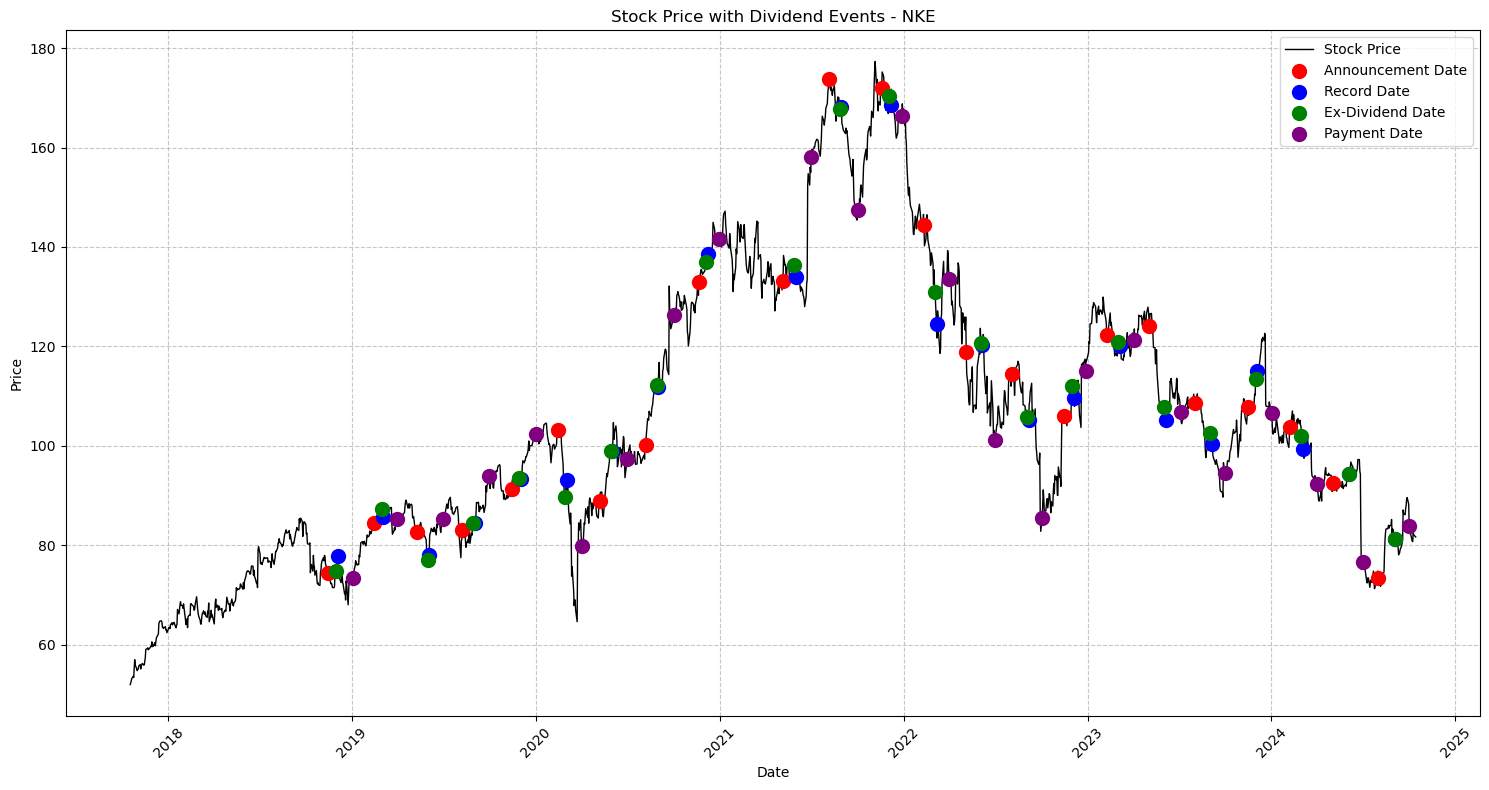

In [13]:
plot_stock_with_events('NKE')

The stock can also be investigated on a specific time frame

C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


<module 'matplotlib.pyplot' from 'C:\\Users\\westm\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

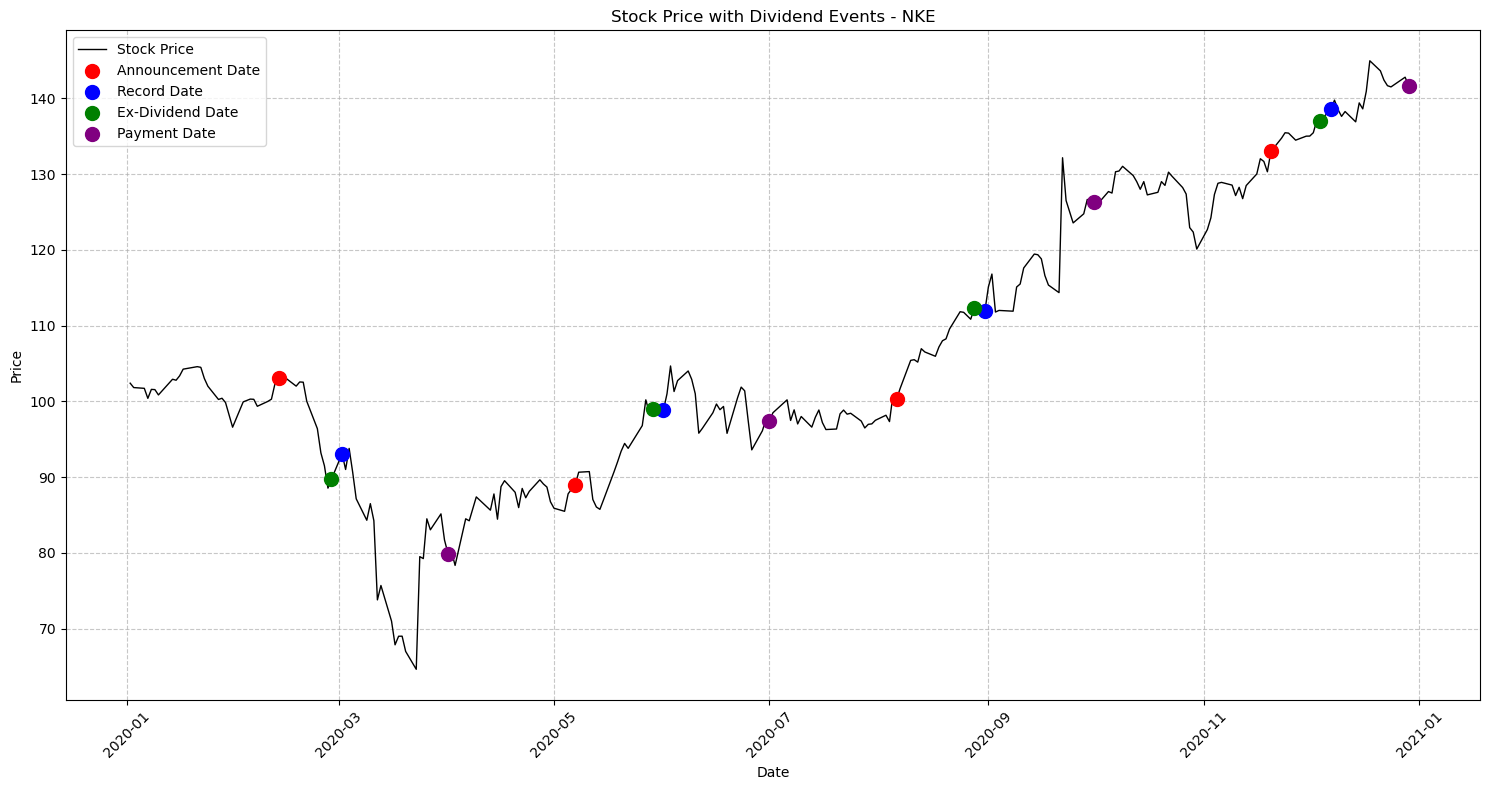

In [14]:
plot_stock_with_events('NKE', start_date='2020-01-01', end_date='2020-12-31')